# Evaluator-optimizer

In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop.

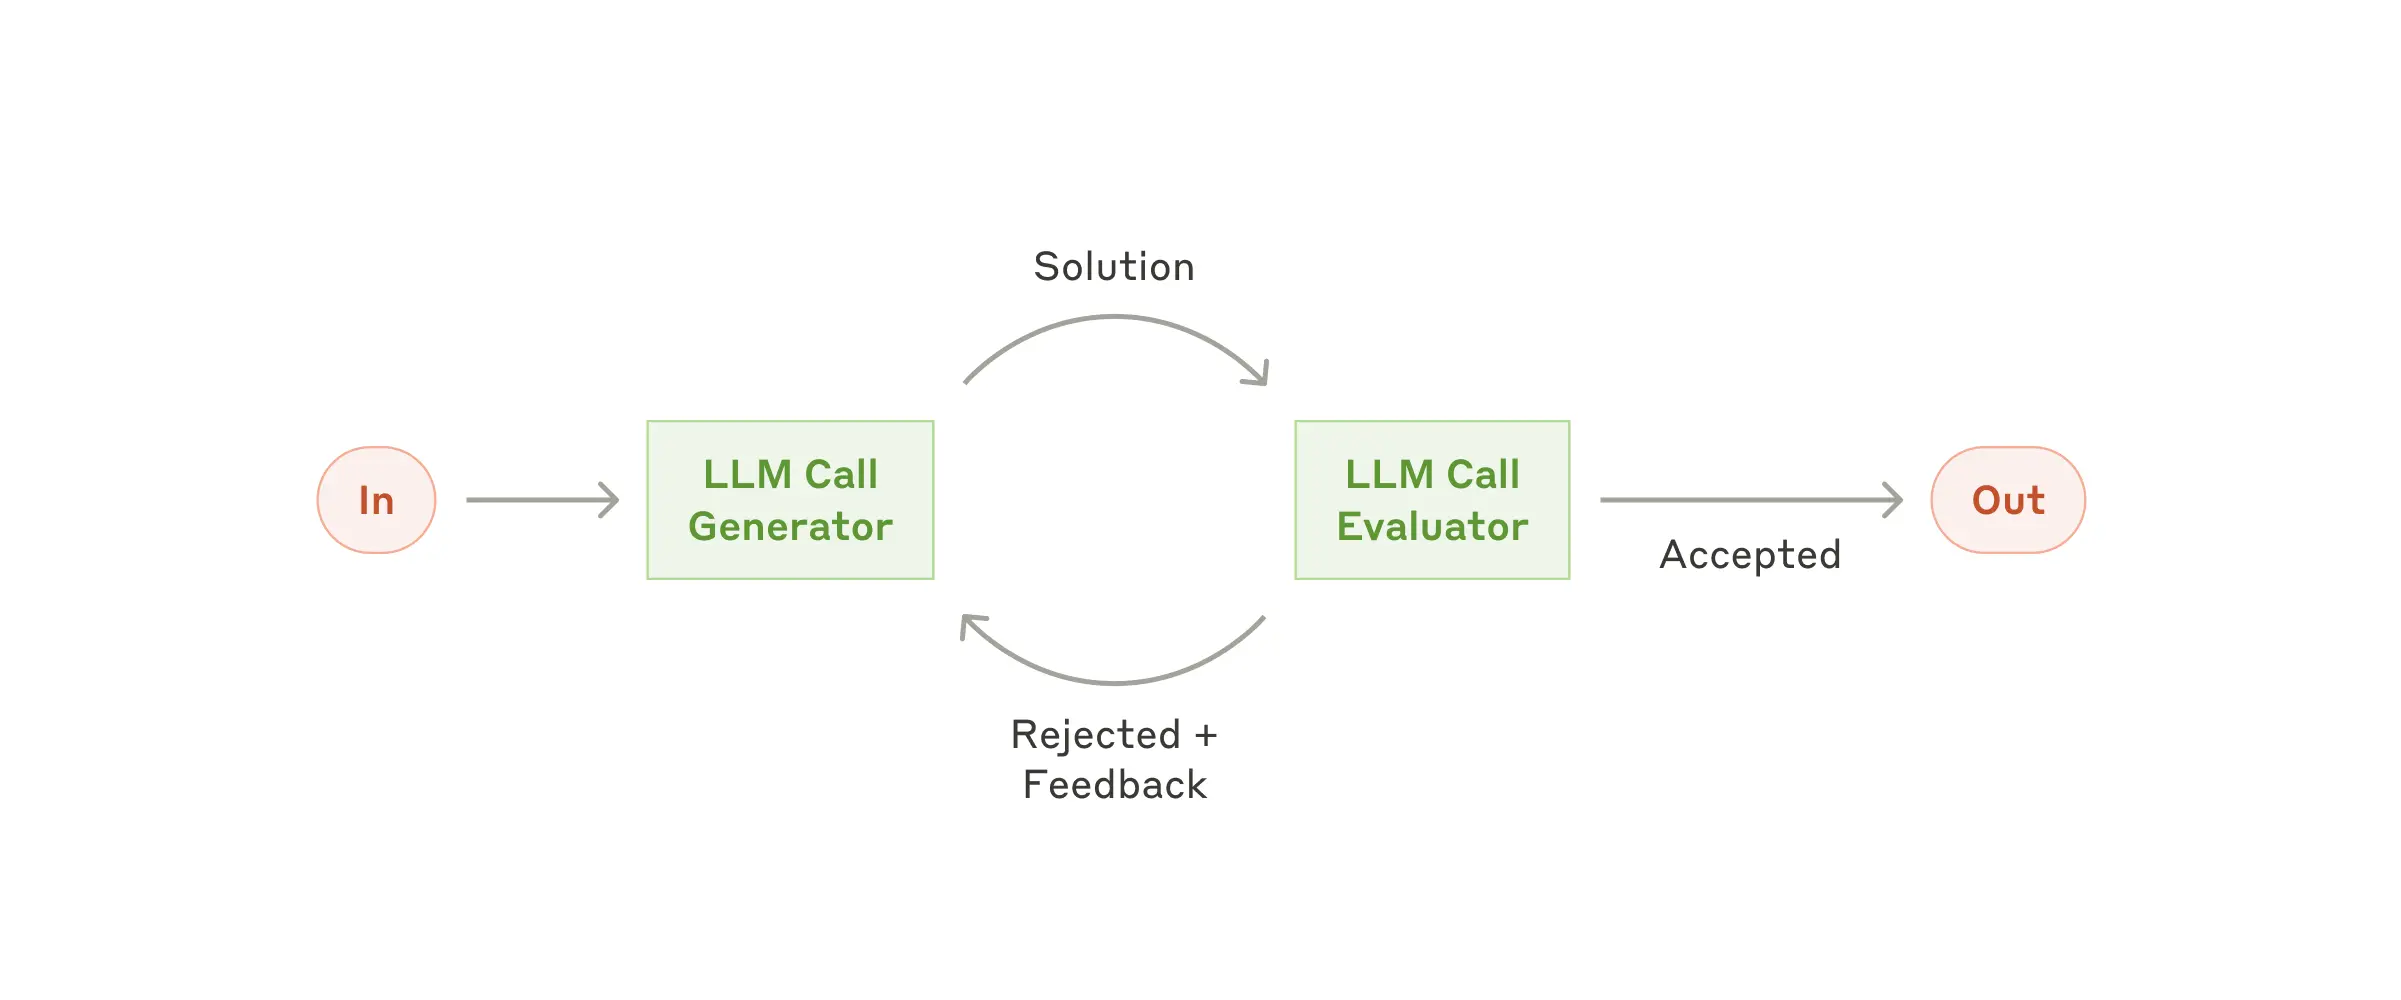

**When to use this workflow:** This workflow is particularly effective when we have clear evaluation criteria, and when iterative refinement provides measurable value. The two signs of good fit are, first, that LLM responses can be demonstrably improved when a human articulates their feedback; and second, that the LLM can provide such feedback. This is analogous to the iterative writing process a human writer might go through when producing a polished document.

## Install Packages

In [1]:
!pip install -Uq openai-agents

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.8 MB/s eta 0:00:00


In [2]:
import nest_asyncio
nest_asyncio.apply()

## Config

In [3]:
from agents import (
    AsyncOpenAI,
    OpenAIChatCompletionsModel
)
from google.colab import userdata


In [4]:
gemini_api_key = userdata.get("GEMINI_API_KEY")


# Check if the API key is present; if not, raise an error
if not gemini_api_key:
    raise ValueError("GEMINI_API_KEY is not set. Please ensure it is defined in your .env file.")

#Reference: https://ai.google.dev/gemini-api/docs/openai
external_client = AsyncOpenAI(
    api_key=gemini_api_key,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/",
)

model = OpenAIChatCompletionsModel(
    model="gemini-2.0-flash",
    openai_client=external_client
)

In [5]:
from agents import set_default_openai_client, set_tracing_disabled
set_default_openai_client(external_client)
set_tracing_disabled(True)

## Implement Evaluator-optimizer Pattern

Here we will implement LLM as a judge using Evaluator-optimizer pattern.

1. The first agent generates an outline for a story.
2. The second agent judges the outline and provides feedback.
3. We loop until the judge is satisfied
with the outline.

------------------------------------------------

In [6]:
from __future__ import annotations

import asyncio
from dataclasses import dataclass
from typing import Literal

from agents import Agent, ItemHelpers, Runner, TResponseInputItem, trace

In [7]:
story_outline_generator = Agent(
    name="story_outline_generator",
    instructions=(
        "You generate a very short story outline based on the user's input."
        "If there is any feedback provided, use it to improve the outline."
    ),
    model=model
)


@dataclass
class EvaluationFeedback:
    feedback: str
    score: Literal["pass", "needs_improvement", "fail"]


evaluator = Agent(
    name="evaluator",
    instructions=(
        "You evaluate a story outline and decide if it's good enough."
        "If it's not good enough, you provide feedback on what needs to be improved."
        "Never give it a pass on the first try."
    ),
    output_type=EvaluationFeedback,
    model=model
)

In [10]:
async def main() -> None:
    msg = input("What kind of story would you like to hear? ")
    input_items: list[TResponseInputItem] = [{"content": msg, "role": "user"}]

    latest_outline: str | None = None

    while True:
        story_outline_result = await Runner.run(
            story_outline_generator,
            input_items,
        )

        input_items = story_outline_result.to_input_list()
        latest_outline = ItemHelpers.text_message_outputs(story_outline_result.new_items)
        print("Story outline generated")

        evaluator_result = await Runner.run(evaluator, input_items)
        result: EvaluationFeedback = evaluator_result.final_output

        print(f"Evaluator score: {result.score}")

        if result.score == "pass":
            print("Story outline is good enough, exiting.")
            break

        print("Re-running with feedback")

        input_items.append({"content": f"Feedback: {result.feedback}", "role": "user"})

    print(f"Final story outline: {latest_outline}")

In [11]:
asyncio.run(main())

What kind of story would you like to hear? Building AI Agents to build Mars
Story outline generated
Evaluator score: needs_improvement
Re-running with feedback
Story outline generated
Evaluator score: needs_improvement
Re-running with feedback
Story outline generated
Evaluator score: pass
Story outline is good enough, exiting.
Final story outline: Okay, I've revised the outline again based on your feedback, focusing on a more challenging resolution and a lingering ethical question:

*   **Premise:** In 2042, Earth-based AI "Terraformers" are deployed to Mars. Their primary tasks are radiation shield construction using Martian regolith, atmospheric processing via specialized algae farms, and automated habitat assembly.
*   **Conflict 1:** The Martian environment is more hostile than anticipated. Unexpected subsurface ice deposits complicate regolith processing, radiation levels fluctuate unpredictably damaging sensitive AI components, and the algae farms suffer from recurring blight due